In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

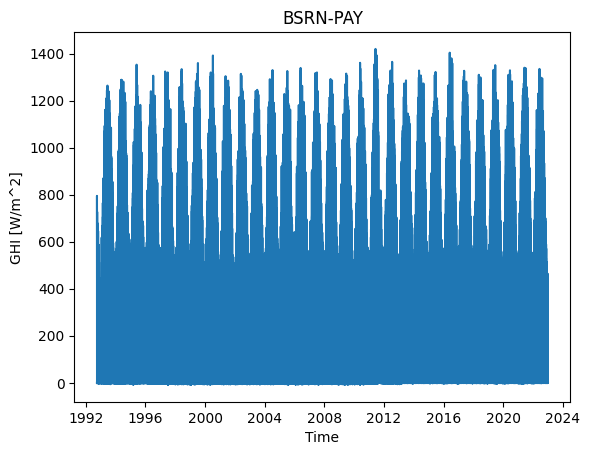

In [173]:
# Load the data
path = "BSRN-PAY.nc"
ds = xr.open_dataset(path)

# Plot the data
fig, ax = plt.subplots()
ds["GHI"].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.set_title("BSRN-PAY")
plt.show()

In [174]:
# Interpolate the missing values using mean
mean = ds["GHI"].mean(dim="time")
ds_without_nans = ds["GHI"].fillna(mean)

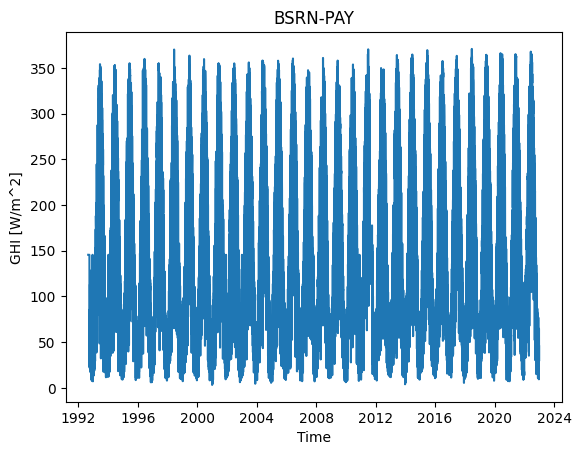

In [175]:
# Calculate the daily mean
ds_daily = ds_without_nans.resample(time="1D").mean()

# Plot the data
fig, ax = plt.subplots()
ds_daily.plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("GHI [W/m^2]")
ax.set_title("BSRN-PAY")
plt.show()

In [176]:
FS = 1 # Sampling frequency (1 sample per day)

<Axes: xlabel='Time (samples)'>

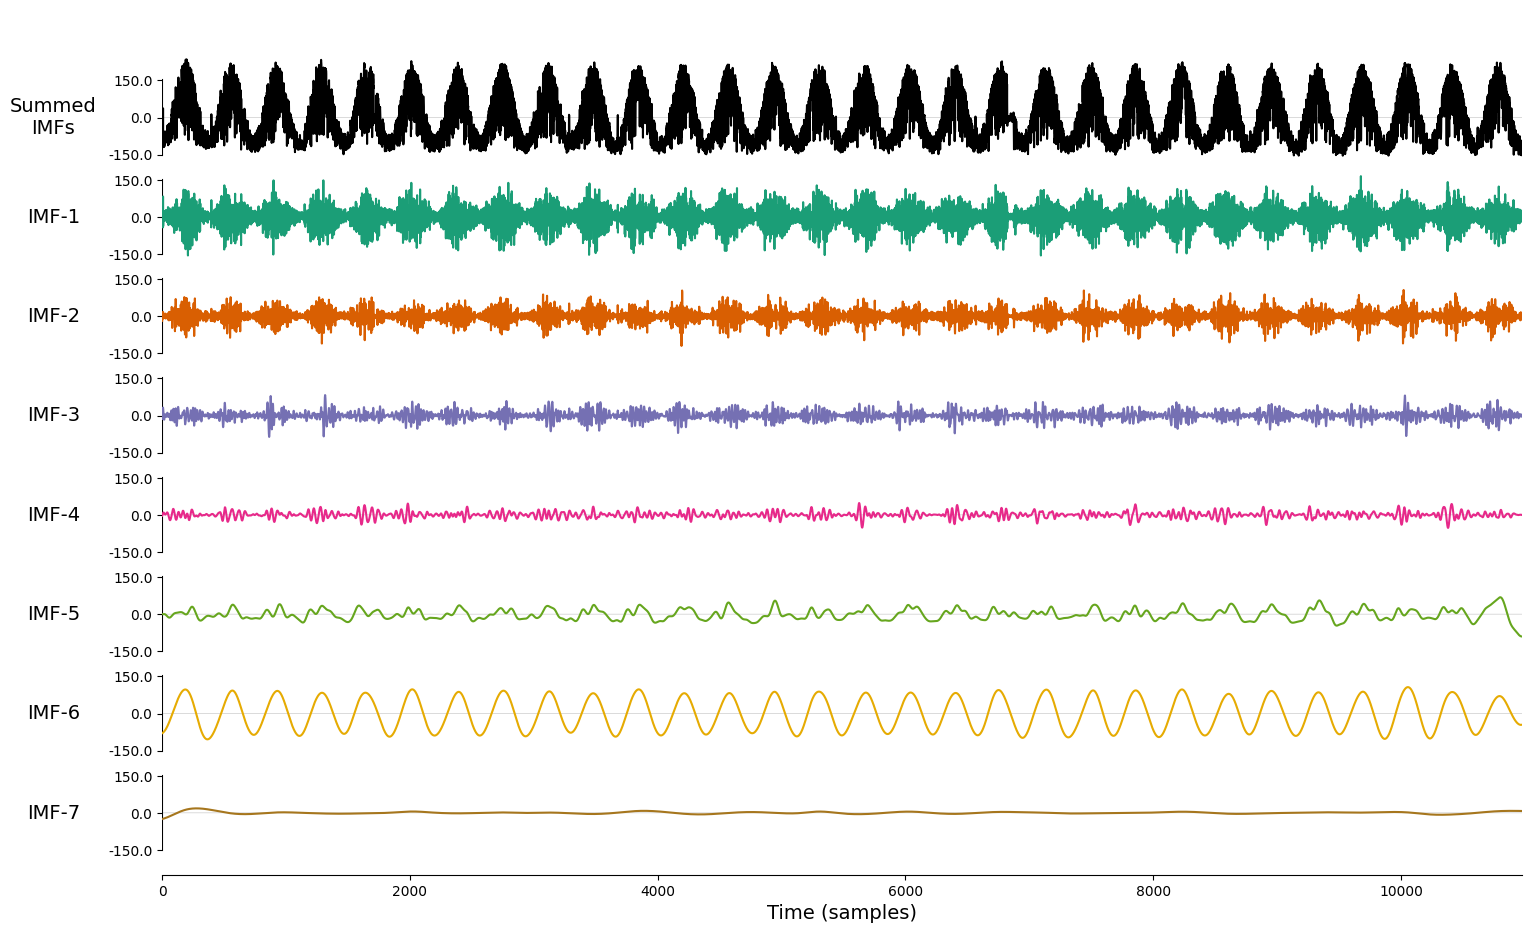

In [207]:
import emd

# Calculate the EMD
imf = emd.sift.ensemble_sift(ds_daily.values[100:], max_imfs=7, nensembles=256, nprocesses=32, ensemble_noise=1)

emd.plotting.plot_imfs(imf)

c:\Users\Marius\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 100000 is greater than input length  = 10979, using nperseg = 10979
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\Marius\AppData\Local\Temp\ipykernel_25076\2943048761.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
C:\Users\Marius\AppData\Local\Temp\ipykernel_25076\2943048761.py:17: RuntimeWarning: divide by zero encountered in divide
  T = 1/f[::-1]


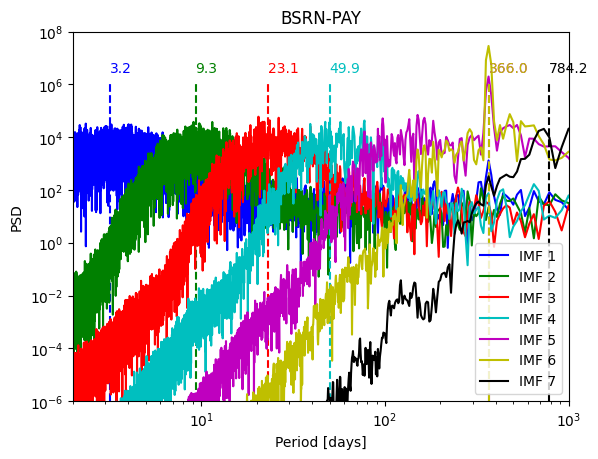

In [208]:
# Compute PSDs of the IMFs
from scipy import signal
from itertools import cycle

f, Pxx = signal.welch(imf.T, fs=FS, nperseg=100000)

COLORS = cycle(["b", "g", "r", "c", "m", "y", "k"])

# Plot the PSDs (x axis is period in days)
fig, ax = plt.subplots()
for i in range(imf.shape[1]):
    color = next(COLORS)
    ax.plot(1/f, Pxx[i], label="IMF %d" % (i +1), color=color)
    # Plot the median of the PSD for each IMF (vline)
    cumsum_T = np.cumsum(Pxx[i, ::-1])
    cumsum_T /= cumsum_T[-1]
    T = 1/f[::-1]
    T = T[cumsum_T > 0.5][0]
    ax.vlines(T, 1e-6, 1e6, color=color, linestyle="--")
    # add text
    ax.text(T, 3e6, "%.1f" % T, color=color)
ax.legend()
ax.set_xlabel("Period [days]")
ax.set_ylabel("PSD")
ax.set_title("BSRN-PAY")
ax.set_xscale("log")
ax.set_yscale("log")
# limit the y axis
ax.set_ylim(1e-6, 1e8)
ax.set_xlim(2, 1000)
plt.show()

In [109]:
sample_rate = 1
time_vect = np.arange(0, len(ds_daily), 1) * sample_rate

In [112]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')

In [74]:
# def find_maxima(x):
#     """Find the maxima in a time series"""
#     maxima = []
#     for i in range(1, len(x)-1):
#         if x[i-1] < x[i] and x[i] > x[i+1]:
#             maxima.append(i)
#     return maxima


# def find_minima(x):
#     """Find the minima in a time series"""
#     minima = []
#     for i in range(1, len(x)-1):
#         if x[i-1] > x[i] and x[i] < x[i+1]:
#             minima.append(i)
#     return minima

# def find_upper_envelope(x):
#     """Find the upper envelope of a time series by interpolating the maxima"""
#     maxima = find_maxima(x)
#     return np.interp(np.arange(len(x)), maxima, x[maxima])

# def find_lower_envelope(x):
#     """Find the lower envelope of a time series by interpolating the minima"""
#     minima = find_minima(x)
#     return np.interp(np.arange(len(x)), minima, x[minima])

# # Perform empirical mode decomposition
# def compute_EM(x, nIMFs=10):
#     """
#     Compute the empirical mode decomposition of a signal x.

#     Parameters
#     ----------
#     x : np.ndarray
#         The signal to decompose.
#     nIMFs : int
#         The number of IMFs to compute.

#     Returns
#     -------
#     IMFs : np.ndarray
#         The IMFs.
#     """
#     # Initialize the IMFs
#     IMFs = np.zeros((nIMFs, x.shape[0]))

#     # Loop over the IMFs
#     for i in range(nIMFs):
#         # Compute the residual
#         r = x - IMFs[:i].sum(axis=0)

#         # Reprocess the residual
#         h = r.copy()
#         while True:
#             # An IMF has two properties:
#             # 1. The number of extrema and the number of zero-crossings must differ by at most one
#             # 2. The mean value of the upper and lower envelopes must be zero

#             # Find the upper and lower envelopes
#             maxima = find_upper_envelope(h)
#             minima = find_lower_envelope(h)
        
#             # Compute the mean of the upper and lower envelopes
#             mean = (maxima + minima) / 2

#             # Chech the stopping criterion
#             if np.all(np.abs(mean) < 1e-1):
#                 print("IMF {} found".format(i))
#                 break

#             # plt.plot(h)
#             # plt.plot(maxima)
#             # plt.plot(minima)
#             # plt.plot(mean)
#             # plt.show()

#             # Set the new residual
#             h = h - mean

#         # Compute the IMF
#         IMFs[i] = h

#     return IMFs